# Augmentation

In [1]:
import os
import shutil
import pathlib

def copy_images_by_class(base_folder, augment_folder):
    """
    Copies images from a base folder to an augment folder, organizing them into
    subfolders based on their class names. This version assumes the class
    name is the *last* directory in the path.

    Args:
        base_folder (str): The root folder containing the original image
                           directory structure (e.g., 'train', 'test', 'val').
        augment_folder (str): The destination folder in the Kaggle working
                            directory where the class folders will be created.
    """
    # Ensure the augment folder exists
    os.makedirs(augment_folder, exist_ok=True)

    # Use pathlib for easier path manipulation
    base_path = pathlib.Path(base_folder)

    # Walk through the directory structure
    for img_path in base_path.glob("**/*"):  # Corrected to use pathlib's glob
        if img_path.is_file() and img_path.suffix.lower() in ('.png', '.jpg', '.jpeg', '.gif', '.bmp'):
            # Get the class name, which is the parent directory name
            class_name = img_path.parent.name
            # Create the destination directory for the class in the augment folder
            class_augment_dir = os.path.join(augment_folder, class_name)
            os.makedirs(class_augment_dir, exist_ok=True)

            # Construct the destination path
            dest_path = os.path.join(class_augment_dir, img_path.name)

            try:
                # Copy the image
                shutil.copy2(str(img_path), dest_path)
                print(f"Copied: {img_path} to {dest_path}")
            except Exception as e:
                print(f"Error copying {img_path}: {e}")

def main():
    """
    Main function to set the source and destination folders and call the copy function.
    """
    # Specify the base folder where your data is located.  Adjust as needed.
    base_folder = '/kaggle/input/normal-tuberculosis-covid/Lung Disease Dataset Covid Normal Tuberculosis'  # Replace

    # Specify the destination folder in the Kaggle working directory
    augment_folder = '/kaggle/working/augmented'

    # Call the function to copy the images
    copy_images_by_class(base_folder, augment_folder)
    print("Image copying and organization complete.")

if __name__ == "__main__":
    main()


Copied: /kaggle/input/normal-tuberculosis-covid/Lung Disease Dataset Covid Normal Tuberculosis/val/Tuberculosis/test_0_5161.jpeg to /kaggle/working/augmented/Tuberculosis/test_0_5161.jpeg
Copied: /kaggle/input/normal-tuberculosis-covid/Lung Disease Dataset Covid Normal Tuberculosis/val/Tuberculosis/test_0_4769.jpeg to /kaggle/working/augmented/Tuberculosis/test_0_4769.jpeg
Copied: /kaggle/input/normal-tuberculosis-covid/Lung Disease Dataset Covid Normal Tuberculosis/val/Tuberculosis/test_0_1443.jpeg to /kaggle/working/augmented/Tuberculosis/test_0_1443.jpeg
Copied: /kaggle/input/normal-tuberculosis-covid/Lung Disease Dataset Covid Normal Tuberculosis/val/Tuberculosis/test_0_5261.jpeg to /kaggle/working/augmented/Tuberculosis/test_0_5261.jpeg
Copied: /kaggle/input/normal-tuberculosis-covid/Lung Disease Dataset Covid Normal Tuberculosis/val/Tuberculosis/Tuberculosis-392.jpg to /kaggle/working/augmented/Tuberculosis/Tuberculosis-392.jpg
Copied: /kaggle/input/normal-tuberculosis-covid/Lung

                  Class  Number of Images
0          Tuberculosis              2034
1                Normal              2013
2  Corona Virus Disease              2031


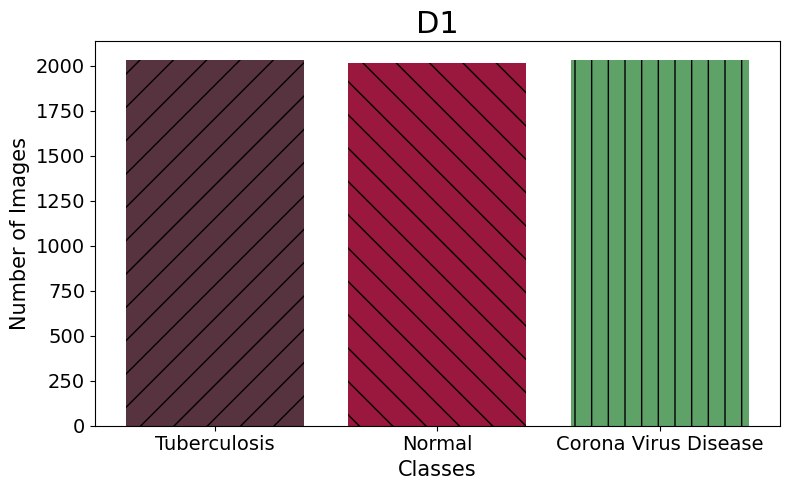

In [2]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Define the path to your dataset directory
dataset_path = "/kaggle/working/augmented"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D1", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('before_augmentation.png', format='png', dpi=600)
plt.show()


In [3]:
import os
from PIL import Image
import numpy as np
from imgaug import augmenters as iaa

# Define paths
input_folder = r'/kaggle/working/augmented/Corona Virus Disease'
output_folder = r'/kaggle/working/augmented/Corona Virus Disease'

# Create the output directory if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')  # Force RGB
                images.append(np.array(img))
                filenames.append(filename)
        except Exception as e:
            print(f"❌ Error loading {img_path}: {e}")
    return images, filenames

# Load original images
images, original_filenames = load_images_from_folder(input_folder)
original_count = len(images)

if original_count == 0:
    print("⚠️ No images found in the input folder. Exiting.")
    exit()

print(f"Found {original_count} original images in the input folder")

# Calculate how many more images we need to generate
target_total = 3000
remaining_needed = max(0, target_total - original_count)

if remaining_needed == 0:
    print(f"✅ Already have {original_count} images, which meets or exceeds the target of {target_total}. No augmentation needed.")
    exit()

print(f"Need to generate {remaining_needed} more images to reach {target_total} total")

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),                  # Horizontal flip
    iaa.Flipud(0.5),                  # Vertical flip
    iaa.Multiply((0.6, 0.8)),         # Adjust brightness
    iaa.Affine(scale=(0.8, 1.0)),     # Zoom in/out
    iaa.Affine(rotate=(-10, 10)),     # Rotate
    iaa.Crop(percent=(0, 0.2)),       # Random crop
])

# Calculate how many augmentations per original image
augmentations_per_image = (remaining_needed // original_count) + 1

# Augment and save images
augmented_count = 0
for i, image in enumerate(images):
    for j in range(augmentations_per_image):
        if augmented_count >= remaining_needed:
            break
        augmented_image = seq(image=image)  # Apply augmentation
        augmented_image_pil = Image.fromarray(augmented_image)
        # Ensure image is RGB before saving as JPG
        if augmented_image_pil.mode != 'RGB':
            augmented_image_pil = augmented_image_pil.convert('RGB')
        output_path = os.path.join(
            output_folder, f'augmented_{i}_{j}.JPG'
        )
        try:
            augmented_image_pil.save(output_path)
            augmented_count += 1
            if augmented_count % 100 == 0:
                print(f"Progress: {augmented_count}/{remaining_needed} augmented images created")
        except Exception as e:
            print(f"❌ Error saving {output_path}: {e}")

final_total = original_count + augmented_count
print(f"✅ Augmentation complete: {augmented_count} new images created")
print(f"✅ Total images in folder: {final_total}/{target_total}")

Found 2031 original images in the input folder
Need to generate 969 more images to reach 3000 total
Progress: 100/969 augmented images created
Progress: 200/969 augmented images created
Progress: 300/969 augmented images created
Progress: 400/969 augmented images created
Progress: 500/969 augmented images created
Progress: 600/969 augmented images created
Progress: 700/969 augmented images created
Progress: 800/969 augmented images created
Progress: 900/969 augmented images created
✅ Augmentation complete: 969 new images created
✅ Total images in folder: 3000/3000


In [4]:
import os
from PIL import Image
import cv2
import numpy as np
from imgaug import augmenters as iaa


# Define paths
input_folder = r'/kaggle/working/augmented/Normal'
# Output directory where augmented images will be saved
output_folder = r'/kaggle/working/augmented/Normal'

# Create the output directory if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
    return images

# Load the original images
images = load_images_from_folder(input_folder)

# Define an augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Multiply((0.6, 0.8)),  # Adjust brightness
    iaa.Affine(scale=(0.8, 1.0)),  # Zoom in/out by 80% to 120%
    iaa.Affine(rotate=(-10, 10)),  # Rotate by -20 to 20 degrees
    iaa.Crop(percent=(0, 0.2)),  # Crop images
])

# Number of augmentations per original image
augmentations_per_image = (3000 - len(images)) // len(images) + 1

# Augment and save images
augmented_count = 0
for i, image in enumerate(images):
    for _ in range(augmentations_per_image):
        augmented_image = seq(image=image)
        augmented_image_pil = Image.fromarray(augmented_image)
        output_path = os.path.join(output_folder, f'augmented_{i}_{augmented_count}.JPG')
        augmented_image_pil.save(output_path)
        augmented_count += 1
        if augmented_count >= (3000 - len(images)):
            break
    if augmented_count >= (3000 - len(images)):
        break

print(f"Augmented images saved in {output_folder}")

Augmented images saved in /kaggle/working/augmented/Normal


In [5]:
import os
from PIL import Image
import cv2
import numpy as np
from imgaug import augmenters as iaa


# Define paths
input_folder = r'/kaggle/working/augmented/Tuberculosis'
# Output directory where augmented images will be saved
output_folder = r'/kaggle/working/augmented/Tuberculosis'

# Create the output directory if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
    return images

# Load the original images
images = load_images_from_folder(input_folder)

# Define an augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Multiply((0.6, 0.8)),  # Adjust brightness
    iaa.Affine(scale=(0.8, 1.0)),  # Zoom in/out by 80% to 120%
    iaa.Affine(rotate=(-10, 10)),  # Rotate by -20 to 20 degrees
    iaa.Crop(percent=(0, 0.2)),  # Crop images
])

# Number of augmentations per original image
augmentations_per_image = (3000 - len(images)) // len(images) + 1

# Augment and save images
augmented_count = 0
for i, image in enumerate(images):
    for _ in range(augmentations_per_image):
        augmented_image = seq(image=image)
        augmented_image_pil = Image.fromarray(augmented_image)
        output_path = os.path.join(output_folder, f'augmented_{i}_{augmented_count}.JPG')
        augmented_image_pil.save(output_path)
        augmented_count += 1
        if augmented_count >= (3000 - len(images)):
            break
    if augmented_count >= (3000 - len(images)):
        break

print(f"Augmented images saved in {output_folder}")

Augmented images saved in /kaggle/working/augmented/Tuberculosis


# EDA

                  Class  Number of Images
0          Tuberculosis              3000
1                Normal              3000
2  Corona Virus Disease              3000


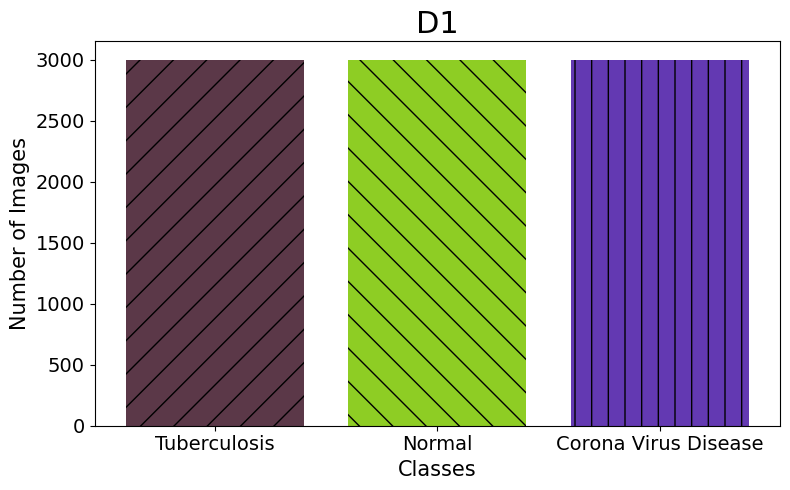

In [6]:
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import itertools
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Define the path to your dataset directory
dataset_path = "/kaggle/working/augmented"

plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(8, 5))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D1", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('after_augmentation.png', format='png', dpi=600)
plt.show()


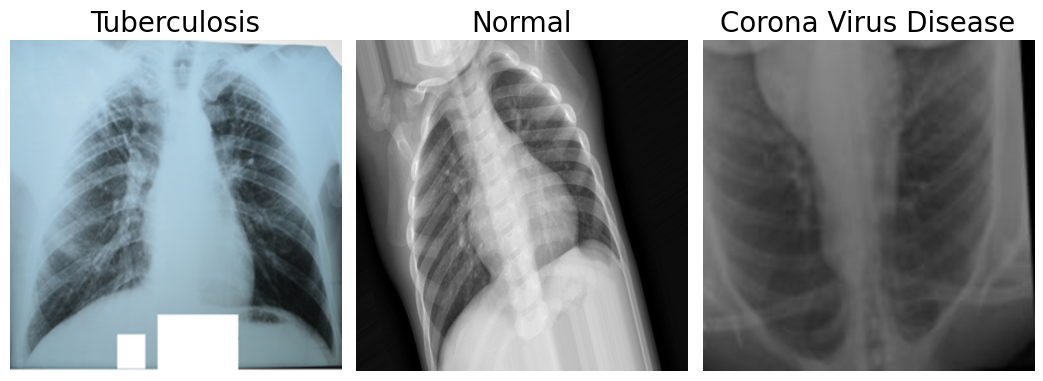

In [7]:
# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Define a transform to resize images and convert them to tensors
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images to 512x512 for uniformity
    transforms.ToTensor()
])

# Initialize a figure for visualization
plt.figure(figsize=(14, 4))  # Adjusted figure size for better clarity with 2 rows and 4 columns

for i, category in enumerate(categories):
    # Get the path of the category folder
    category_path = os.path.join(dataset_path, category)

    # Get the list of image files in the category folder
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]

    # Ensure there is at least one image in the category
    if not image_files:
        print(f"No images found in category: {category}")
        continue

    # Randomly select an image from the category
    image_path = os.path.join(category_path, random.choice(image_files))
    image = Image.open(image_path).convert("RGB")

    # Apply the transform
    image = transform(image)

    # Convert the tensor back to a PIL image for visualization
    image = transforms.ToPILImage()(image)

    # Add the image to the plot
    plt.subplot(1, 4, i + 1)  # Updated to 2 rows and 4 columns
    plt.imshow(image)
    plt.title(category, fontsize=20)  # Increased font size for category labels
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('D3sample.png', format='png', dpi=600)
plt.show()

# Training

In [8]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
data_dir = "/kaggle/working/augmented"

In [10]:
# Custom dataset loader for image data
class CustomImageDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.filepaths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load data

def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

# data_dir = "F:\\Ml files\\XAI\\Grape\\Combined (D4)"
df = loading_the_data(data_dir)

                  Class  Number of Images
0          Tuberculosis              3000
1                Normal              3000
2  Corona Virus Disease              3000


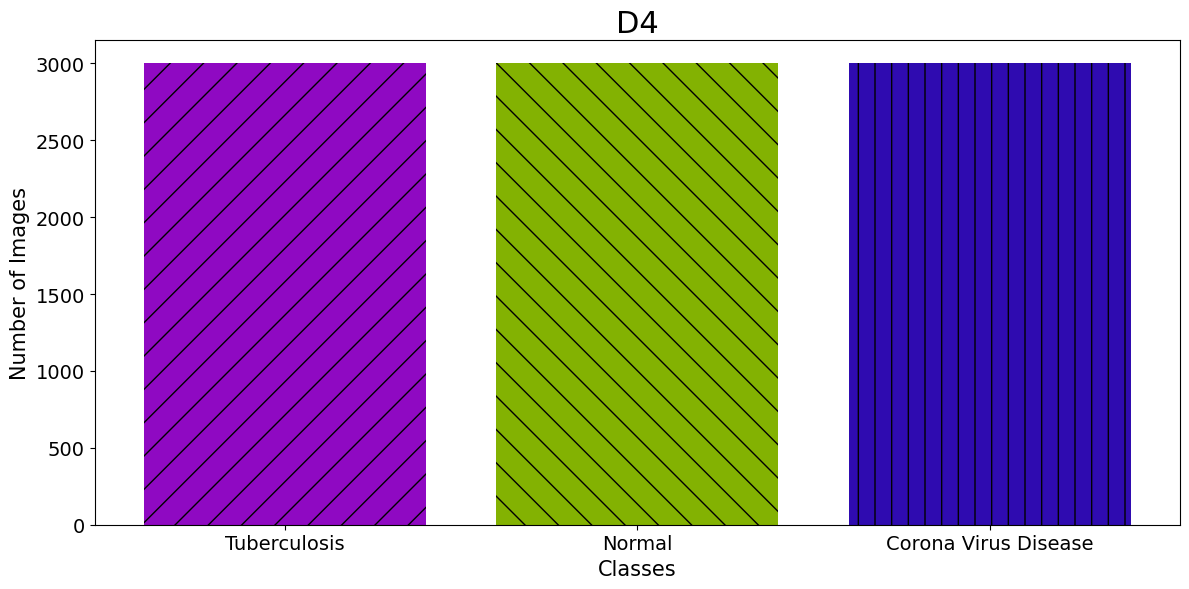

In [11]:
import random
plt.style.use('default')

# Get the list of categories (subfolder names)
categories = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Count the number of images in each category
image_counts = []
for category in categories:
    category_path = os.path.join(data_dir, category)
    image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]
    image_counts.append(len(image_files))

# Create a dataframe to show the number of images per class
data = pd.DataFrame({"Class": categories, "Number of Images": image_counts})
print(data)


# Create a bar chart to visualize the number of images in each category
plt.figure(figsize=(12, 6))
patterns = ["/", "\\", "|", "-", "+", "x", "o", "*"]  # Define patterns for bars
colors = ["#" + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in categories]  # Generate unique colors
bars = plt.bar(categories, image_counts, color=colors)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.title("D4", fontsize=22)
plt.xlabel("Classes", fontsize=15)
plt.ylabel("Number of Images", fontsize=15)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('D1_barchart.png', format='png', dpi=600)
plt.show()

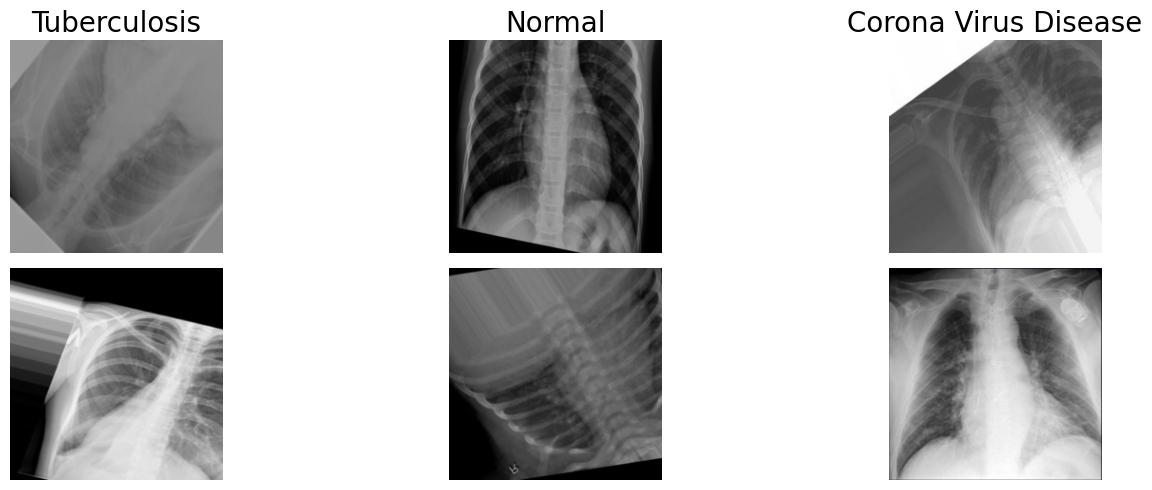

In [12]:
from PIL import Image

# Define a transform to resize images and convert them to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 512x512 for uniformity
    transforms.ToTensor()
])

# Number of rows and columns
rows, cols = 2, 3

# Ensure categories list contains at least `cols` categories
if len(categories) < cols:
    raise ValueError("Not enough categories to display.")

# Initialize a figure for visualization
plt.figure(figsize=(15, 5))  # Adjusted figure size for better clarity with 2 rows and 5 columns

# Iterate twice to create two rows with different images from the same categories
for row in range(rows):
    for col, category in enumerate(categories[:cols]):  # Use the first `cols` categories
        # Get the path of the category folder
        category_path = os.path.join(data_dir, category)

        # Get the list of image files in the category folder
        image_files = [file for file in os.listdir(category_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]

        # Ensure there is at least one image in the category
        if not image_files:
            print(f"No images found in category: {category}")
            continue

        # Randomly select an image from the category
        image_path = os.path.join(category_path, random.choice(image_files))
        image = Image.open(image_path).convert("RGB")

        # Apply the transform
        image = transform(image)

        # Convert the tensor back to a PIL image for visualization
        image = transforms.ToPILImage()(image)

        # Add the image to the plot
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.imshow(image)
        
        # Set title only for the first row
        if row == 0:
            plt.title(category, fontsize=20)
        
        plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('D1 sample.png', format='png', dpi=600)
plt.show()

In [13]:
# Data transformation
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Splitting data
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.75, stratify=temp_df['labels'], random_state=42)  # 75% of temp (15% of total) for test

In [15]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(7200, 2)
(450, 2)
(1350, 2)


In [16]:
import pandas as pd

# Assuming train_df, val_df, and test_df have a 'labels' column
train_counts = train_df['labels'].value_counts()
val_counts = val_df['labels'].value_counts()
test_counts = test_df['labels'].value_counts()

# Combine into a single DataFrame
class_counts = pd.DataFrame({
    'Training': train_counts,
    'Validation': val_counts,
    'Testing': test_counts
}).fillna(0).astype(int)  # Fill NaN with 0 and convert to integer

# Add a column for total counts (optional)
class_counts['Total'] = class_counts.sum(axis=1)

# Display the table
print(class_counts)


                      Training  Validation  Testing  Total
labels                                                    
Corona Virus Disease      2400         150      450   3000
Normal                    2400         150      450   3000
Tuberculosis              2400         150      450   3000


In [17]:
# Encoding labels
label_mapping = {label: idx for idx, label in enumerate(df['labels'].unique())}
train_labels = train_df['labels'].map(label_mapping).values
val_labels = val_df['labels'].map(label_mapping).values
test_labels = test_df['labels'].map(label_mapping).values

# Creating datasets and loaders
train_dataset = CustomImageDataset(train_df['filepaths'].values, train_labels, transform=data_transform)
val_dataset = CustomImageDataset(val_df['filepaths'].values, val_labels, transform=data_transform)
test_dataset = CustomImageDataset(test_df['filepaths'].values, test_labels, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

In [18]:
# Model setup
if not torch.cuda.is_available():
    raise RuntimeError('CUDA device is not available. Please ensure a GPU is available to train the model.')
device = torch.device('cuda')
device

device(type='cuda')

# Resnext 50

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNeXt-50 model
model = models.resnext50_32x4d(pretrained=True)

# Get the number of input features from the original classifier
num_ftrs = model.fc.in_features

# Replace the classifier (fully connected layer) with a new one
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(label_mapping)),  # Adjust output layer to the number of classes
    nn.LogSoftmax(dim=1)
)

# Move the model to the specified device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model initialized and ready for training!")


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 123MB/s]


Model initialized and ready for training!


Epoch 1/20
----------


Validation Loss: 0.2014, Validation Accuracy: 0.9222
Epoch 1/20, Loss: 0.3582, Accuracy: 0.8697
Epoch 2/20
----------


Validation Loss: 0.1376, Validation Accuracy: 0.9467
Epoch 2/20, Loss: 0.2270, Accuracy: 0.9206
Epoch 3/20
----------


Validation Loss: 0.1471, Validation Accuracy: 0.9467
Epoch 3/20, Loss: 0.1749, Accuracy: 0.9411
Epoch 4/20
----------


Validation Loss: 0.2302, Validation Accuracy: 0.9133
Epoch 4/20, Loss: 0.1678, Accuracy: 0.9421
Epoch 5/20
----------


Validation Loss: 0.0706, Validation Accuracy: 0.9756
Epoch 5/20, Loss: 0.1401, Accuracy: 0.9507
Epoch 6/20
----------


Validation Loss: 0.0861, Validation Accuracy: 0.9622
Epoch 6/20, Loss: 0.1253, Accuracy: 0.9543
Epoch 7/20
----------


Validation Loss: 0.1193, Validation Accuracy: 0.9578
Epoch 7/20, Loss: 0.1180, Accuracy: 0.9578
Epoch 8/20
----------


Validation Loss: 0.0789, Validation Accuracy: 0.9711
Epoch 8/20, Loss: 0.0963, Accuracy: 0.9671
Epoch 9/20
----------


Validation Loss: 0.2654, Validation Accuracy: 0.9089
Epoch 9/20, Loss: 0.1149, Accuracy: 0.9622
Epoch 10/20
----------


Validation Loss: 0.1618, Validation Accuracy: 0.9533
Epoch 10/20, Loss: 0.1091, Accuracy: 0.9628
Epoch 11/20
----------


Validation Loss: 0.0495, Validation Accuracy: 0.9800
Epoch 11/20, Loss: 0.0827, Accuracy: 0.9701
Epoch 12/20
----------


Validation Loss: 0.1372, Validation Accuracy: 0.9422
Epoch 12/20, Loss: 0.1219, Accuracy: 0.9611
Epoch 13/20
----------


Validation Loss: 0.0473, Validation Accuracy: 0.9844
Epoch 13/20, Loss: 0.1070, Accuracy: 0.9651
Epoch 14/20
----------


Validation Loss: 0.1452, Validation Accuracy: 0.9422
Epoch 14/20, Loss: 0.0848, Accuracy: 0.9728
Epoch 15/20
----------


Validation Loss: 0.0402, Validation Accuracy: 0.9889
Epoch 15/20, Loss: 0.0669, Accuracy: 0.9767
Epoch 16/20
----------


Validation Loss: 0.0728, Validation Accuracy: 0.9756
Epoch 16/20, Loss: 0.0752, Accuracy: 0.9757
Epoch 17/20
----------


Validation Loss: 0.0649, Validation Accuracy: 0.9733
Epoch 17/20, Loss: 0.0661, Accuracy: 0.9751
Epoch 18/20
----------


Validation Loss: 0.0713, Validation Accuracy: 0.9733
Epoch 18/20, Loss: 0.0716, Accuracy: 0.9788
Epoch 19/20
----------


Validation Loss: 0.0513, Validation Accuracy: 0.9867
Epoch 19/20, Loss: 0.0729, Accuracy: 0.9753
Epoch 20/20
----------


Validation Loss: 0.0452, Validation Accuracy: 0.9867
Epoch 20/20, Loss: 0.0488, Accuracy: 0.9844


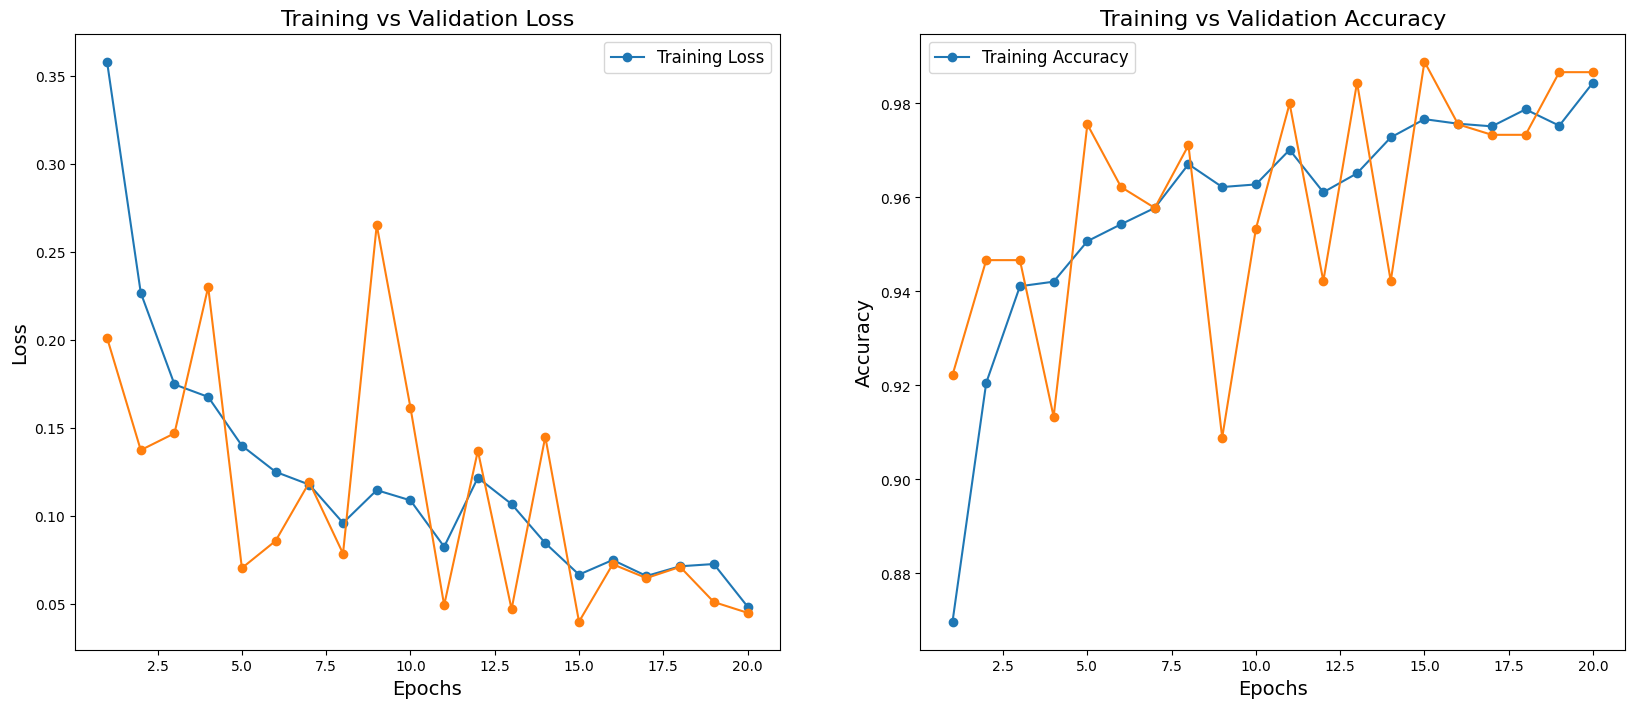

In [20]:
# Training function with learning curve
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses= []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Plot learning curve
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Confusion Matrix:
[[149   0   1]
 [  0 149   1]
 [  4   0 146]]


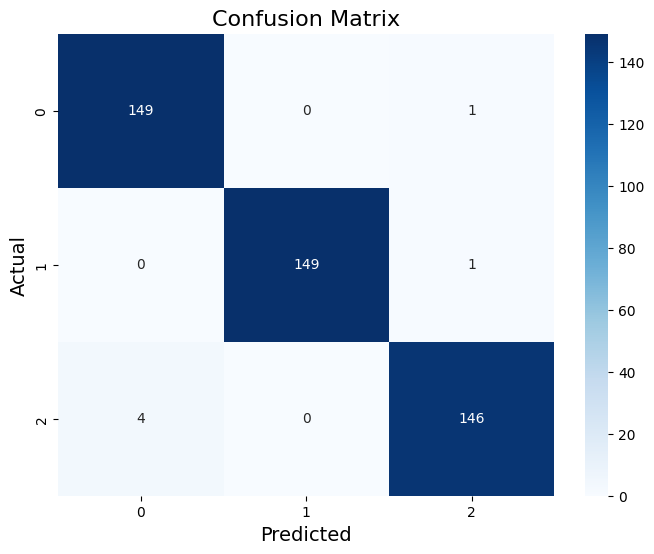

Specificity is only defined for binary classification.
Matthews Correlation Coefficient (MCC): 0.9801
F1 Score: 0.9867
PR AUC is usually computed for binary classification.

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       1.00      0.99      1.00       150
           2       0.99      0.97      0.98       150

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [21]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    # Try to fetch class names from dataset
    try:
        class_names = data_loader.dataset.classes
    except AttributeError:
        class_names = None

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Use softmax for multi-class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # For PR-AUC: assuming binary — take class 1 probability
            if probs.shape[1] == 2:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs.cpu().numpy())  # Multi-class: you can adjust this

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(len(cm)),
                yticklabels=class_names if class_names else np.arange(len(cm)))
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # --- Specificity ---
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Specificity is only defined for binary classification.")

    # --- Matthews Correlation Coefficient ---
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # --- F1 Score ---
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # --- PR AUC ---
    if len(np.unique(all_labels)) == 2:
        precision, recall, _ = precision_recall_curve(all_labels, np.array(all_probs))
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("PR AUC is usually computed for binary classification.")

    # --- Classification Report ---
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print("\nClassification Report:\n", report)
    
evaluate_model(model, val_loader)

In [22]:
# Save the model
torch.save(model.state_dict(), "resnext50.pth")

In [23]:
model_resnetx50 = model

# DenseNet-201

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained DenseNet-201 model
model = models.densenet201(pretrained=True)

# Get the number of input features from the original classifier
num_ftrs = model.classifier.in_features  # DenseNet uses a `classifier` instead of `fc`

# Replace the classifier (fully connected layer) with a new one
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(label_mapping)),  # Adjust output layer to the number of classes
    nn.LogSoftmax(dim=1)
)

# Move the model to the specified device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("DenseNet-201 model initialized and ready for training!")


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 198MB/s]


DenseNet-201 model initialized and ready for training!


Epoch 1/20
----------


Validation Loss: 0.3026, Validation Accuracy: 0.8689
Epoch 1/20, Loss: 0.3903, Accuracy: 0.8499
Epoch 2/20
----------


Validation Loss: 0.2970, Validation Accuracy: 0.9000
Epoch 2/20, Loss: 0.2384, Accuracy: 0.9106
Epoch 3/20
----------


Validation Loss: 0.2869, Validation Accuracy: 0.9067
Epoch 3/20, Loss: 0.1974, Accuracy: 0.9268
Epoch 4/20
----------


Validation Loss: 0.1566, Validation Accuracy: 0.9422
Epoch 4/20, Loss: 0.1607, Accuracy: 0.9439
Epoch 5/20
----------


Validation Loss: 0.1039, Validation Accuracy: 0.9578
Epoch 5/20, Loss: 0.1473, Accuracy: 0.9485
Epoch 6/20
----------


Validation Loss: 0.1585, Validation Accuracy: 0.9467
Epoch 6/20, Loss: 0.1246, Accuracy: 0.9592
Epoch 7/20
----------


Validation Loss: 0.1192, Validation Accuracy: 0.9533
Epoch 7/20, Loss: 0.1055, Accuracy: 0.9625
Epoch 8/20
----------


Validation Loss: 0.0508, Validation Accuracy: 0.9844
Epoch 8/20, Loss: 0.1047, Accuracy: 0.9654
Epoch 9/20
----------


Validation Loss: 0.0903, Validation Accuracy: 0.9711
Epoch 9/20, Loss: 0.0846, Accuracy: 0.9703
Epoch 10/20
----------


Validation Loss: 0.0542, Validation Accuracy: 0.9778
Epoch 10/20, Loss: 0.1039, Accuracy: 0.9632
Epoch 11/20
----------


Validation Loss: 0.0512, Validation Accuracy: 0.9844
Epoch 11/20, Loss: 0.0630, Accuracy: 0.9772
Epoch 12/20
----------


Validation Loss: 0.1404, Validation Accuracy: 0.9533
Epoch 12/20, Loss: 0.0850, Accuracy: 0.9740
Epoch 13/20
----------


Validation Loss: 0.0608, Validation Accuracy: 0.9733
Epoch 13/20, Loss: 0.0831, Accuracy: 0.9717
Epoch 14/20
----------


Validation Loss: 0.0713, Validation Accuracy: 0.9622
Epoch 14/20, Loss: 0.0645, Accuracy: 0.9762
Epoch 15/20
----------


Validation Loss: 0.0462, Validation Accuracy: 0.9889
Epoch 15/20, Loss: 0.0661, Accuracy: 0.9776
Epoch 16/20
----------


Validation Loss: 0.0735, Validation Accuracy: 0.9800
Epoch 16/20, Loss: 0.0839, Accuracy: 0.9738
Epoch 17/20
----------


Validation Loss: 0.1787, Validation Accuracy: 0.9400
Epoch 17/20, Loss: 0.0445, Accuracy: 0.9860
Epoch 18/20
----------


Validation Loss: 0.0431, Validation Accuracy: 0.9867
Epoch 18/20, Loss: 0.0626, Accuracy: 0.9790
Epoch 19/20
----------


Validation Loss: 0.1905, Validation Accuracy: 0.9378
Epoch 19/20, Loss: 0.0659, Accuracy: 0.9783
Epoch 20/20
----------


Validation Loss: 0.0446, Validation Accuracy: 0.9822
Epoch 20/20, Loss: 0.0721, Accuracy: 0.9767


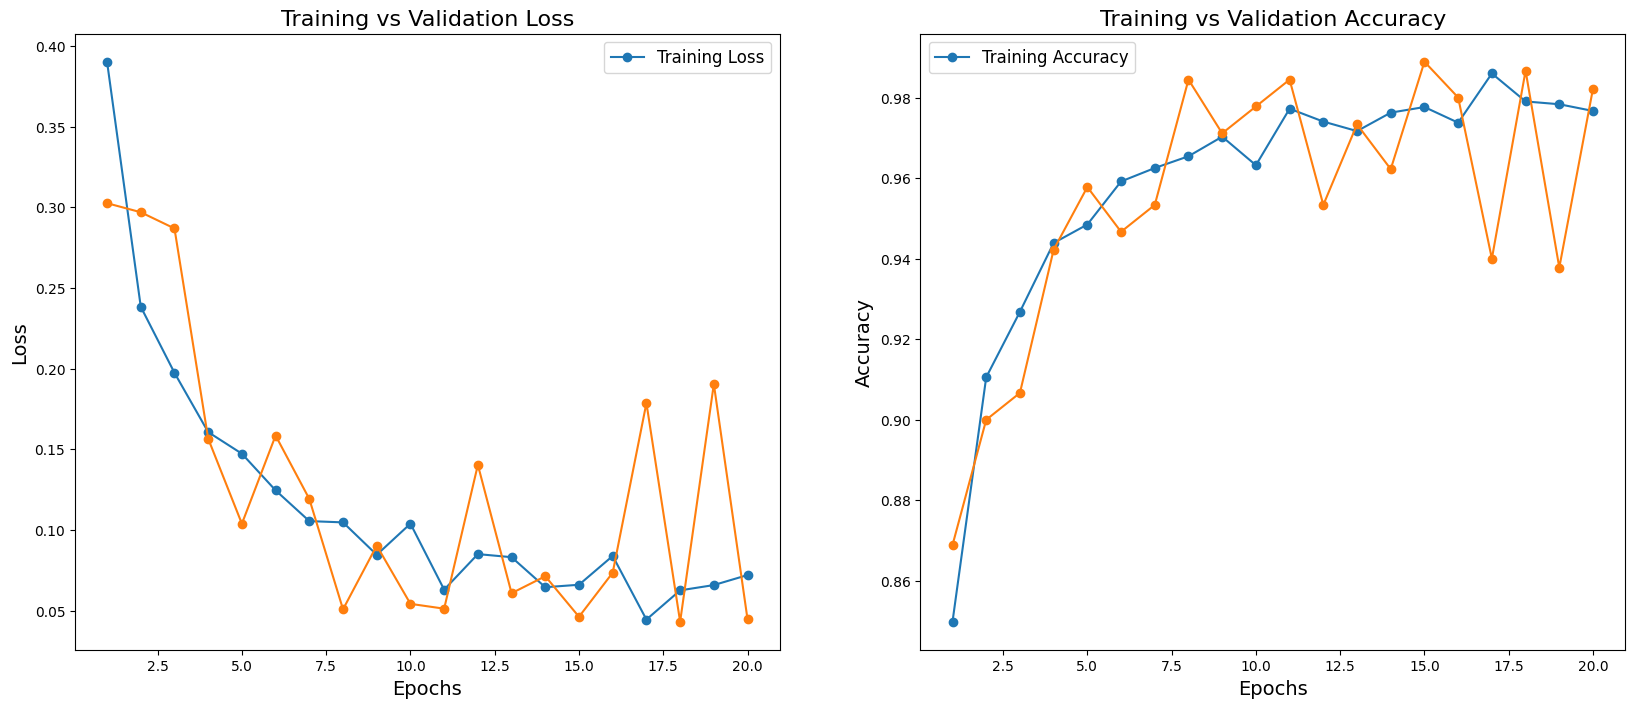

In [25]:
# Training function with learning curve
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses= []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Plot learning curve
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Confusion Matrix:
[[145   0   5]
 [  0 149   1]
 [  2   0 148]]


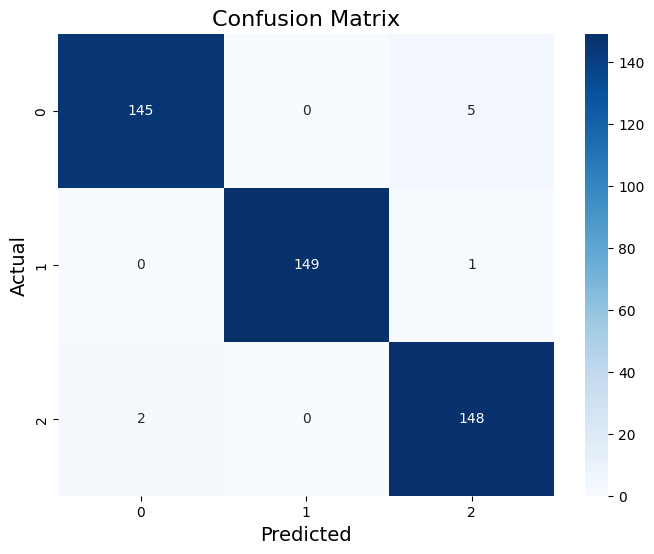

Specificity is only defined for binary classification.
Matthews Correlation Coefficient (MCC): 0.9734
F1 Score: 0.9823
PR AUC is usually computed for binary classification.

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       1.00      0.99      1.00       150
           2       0.96      0.99      0.97       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [26]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    # Try to fetch class names from dataset
    try:
        class_names = data_loader.dataset.classes
    except AttributeError:
        class_names = None

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Use softmax for multi-class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # For PR-AUC: assuming binary — take class 1 probability
            if probs.shape[1] == 2:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs.cpu().numpy())  # Multi-class: you can adjust this

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(len(cm)),
                yticklabels=class_names if class_names else np.arange(len(cm)))
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # --- Specificity ---
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Specificity is only defined for binary classification.")

    # --- Matthews Correlation Coefficient ---
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # --- F1 Score ---
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # --- PR AUC ---
    if len(np.unique(all_labels)) == 2:
        precision, recall, _ = precision_recall_curve(all_labels, np.array(all_probs))
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("PR AUC is usually computed for binary classification.")

    # --- Classification Report ---
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print("\nClassification Report:\n", report)
    
evaluate_model(model, val_loader)

In [27]:
# Save the model
torch.save(model.state_dict(), "densenet201.pth")

In [28]:
model_densenet201 = model

# ShuffleNet v2

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ShuffleNet v2 (1.0x output channels)
model = models.shufflenet_v2_x1_0(pretrained=True)

# Get the number of input features to the classifier
num_ftrs = model.fc.in_features  # For ShuffleNet, the classifier is `fc`

# Replace the classifier
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(label_mapping)),  # Use your actual number of classes
    nn.LogSoftmax(dim=1)
)

# Move model to device
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("ShuffleNet v2 model (via torchvision) initialized and ready for training!")


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 89.5MB/s]


ShuffleNet v2 model (via torchvision) initialized and ready for training!


Epoch 1/20
----------


Validation Loss: 0.0780, Validation Accuracy: 0.9756
Epoch 1/20, Loss: 0.2111, Accuracy: 0.9250
Epoch 2/20
----------


Validation Loss: 0.0588, Validation Accuracy: 0.9800
Epoch 2/20, Loss: 0.0891, Accuracy: 0.9701
Epoch 3/20
----------


Validation Loss: 0.0461, Validation Accuracy: 0.9844
Epoch 3/20, Loss: 0.0732, Accuracy: 0.9739
Epoch 4/20
----------


Validation Loss: 0.1251, Validation Accuracy: 0.9600
Epoch 4/20, Loss: 0.0554, Accuracy: 0.9810
Epoch 5/20
----------


Validation Loss: 0.1251, Validation Accuracy: 0.9556
Epoch 5/20, Loss: 0.0585, Accuracy: 0.9807
Epoch 6/20
----------


Validation Loss: 0.0497, Validation Accuracy: 0.9844
Epoch 6/20, Loss: 0.0466, Accuracy: 0.9821
Epoch 7/20
----------


Validation Loss: 0.0425, Validation Accuracy: 0.9889
Epoch 7/20, Loss: 0.0336, Accuracy: 0.9881
Epoch 8/20
----------


Validation Loss: 0.0590, Validation Accuracy: 0.9778
Epoch 8/20, Loss: 0.0470, Accuracy: 0.9832
Epoch 9/20
----------


Validation Loss: 0.0917, Validation Accuracy: 0.9600
Epoch 9/20, Loss: 0.0338, Accuracy: 0.9885
Epoch 10/20
----------


Validation Loss: 0.0274, Validation Accuracy: 0.9933
Epoch 10/20, Loss: 0.0429, Accuracy: 0.9868
Epoch 11/20
----------


Validation Loss: 0.0605, Validation Accuracy: 0.9800
Epoch 11/20, Loss: 0.0210, Accuracy: 0.9921
Epoch 12/20
----------


Validation Loss: 0.0665, Validation Accuracy: 0.9800
Epoch 12/20, Loss: 0.0216, Accuracy: 0.9929
Epoch 13/20
----------


Validation Loss: 0.0185, Validation Accuracy: 0.9933
Epoch 13/20, Loss: 0.0335, Accuracy: 0.9890
Epoch 14/20
----------


Validation Loss: 0.0359, Validation Accuracy: 0.9822
Epoch 14/20, Loss: 0.0283, Accuracy: 0.9910
Epoch 15/20
----------


Validation Loss: 0.0315, Validation Accuracy: 0.9889
Epoch 15/20, Loss: 0.0236, Accuracy: 0.9919
Epoch 16/20
----------


Validation Loss: 0.0132, Validation Accuracy: 0.9956
Epoch 16/20, Loss: 0.0228, Accuracy: 0.9938
Epoch 17/20
----------


Validation Loss: 0.0643, Validation Accuracy: 0.9800
Epoch 17/20, Loss: 0.0241, Accuracy: 0.9919
Epoch 18/20
----------


Validation Loss: 0.1430, Validation Accuracy: 0.9689
Epoch 18/20, Loss: 0.0353, Accuracy: 0.9886
Epoch 19/20
----------


Validation Loss: 0.0335, Validation Accuracy: 0.9889
Epoch 19/20, Loss: 0.0217, Accuracy: 0.9917
Epoch 20/20
----------


Validation Loss: 0.0780, Validation Accuracy: 0.9756
Epoch 20/20, Loss: 0.0111, Accuracy: 0.9956


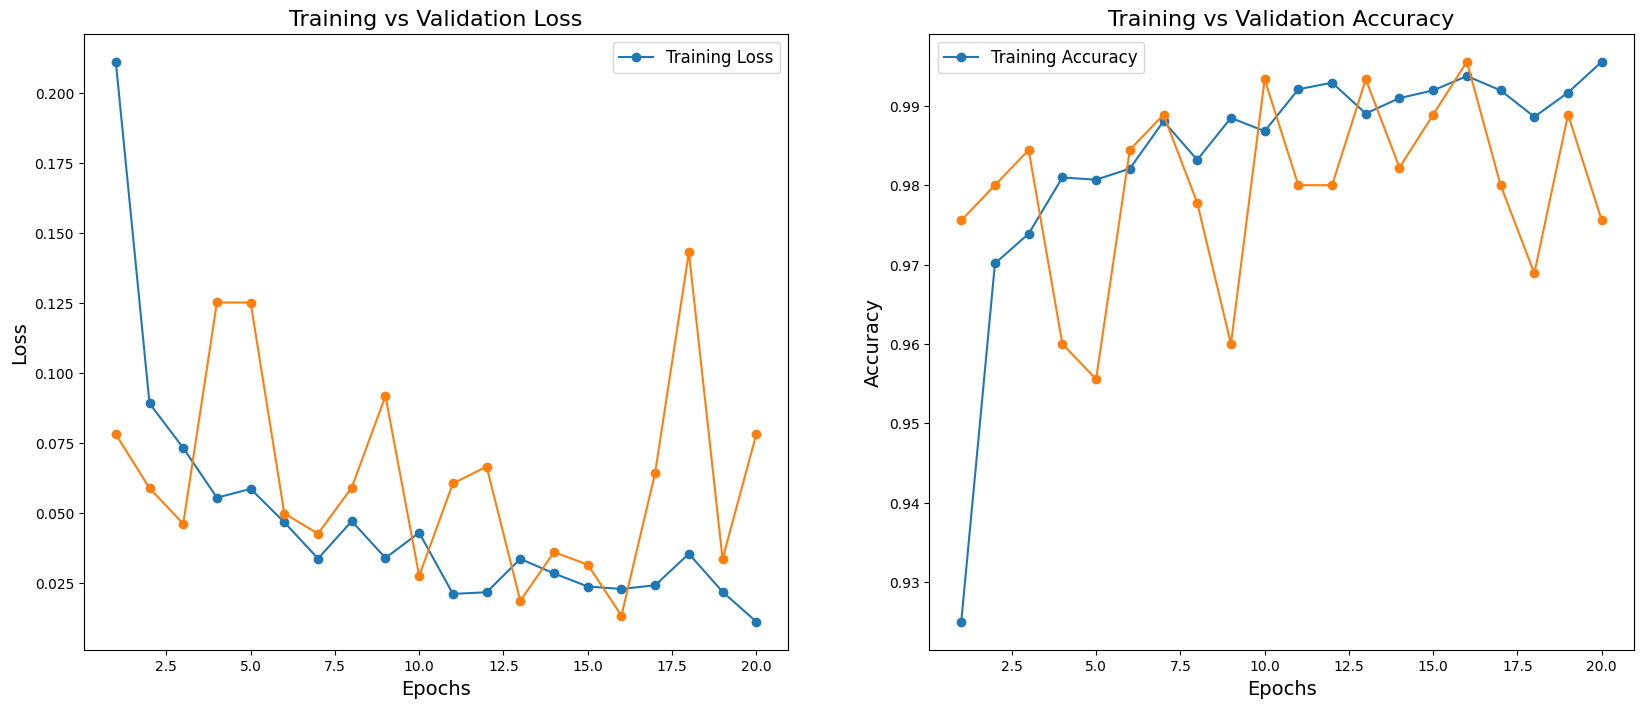

In [30]:
# Training function with learning curve
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses= []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Plot learning curve
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Confusion Matrix:
[[149   0   1]
 [  0 149   1]
 [  8   1 141]]


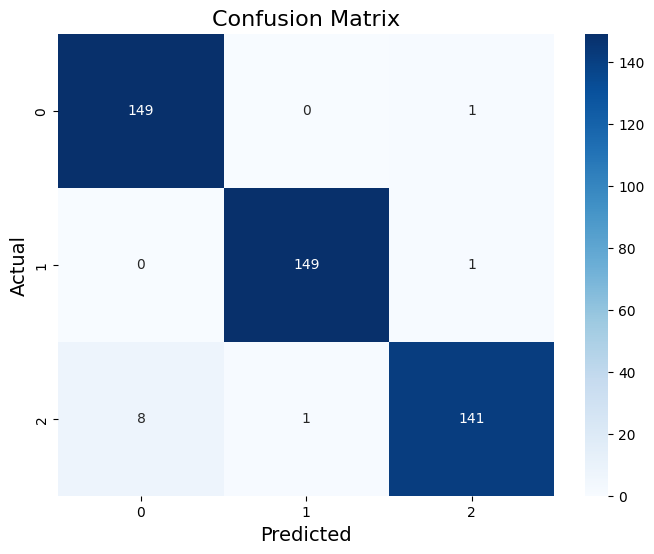

Specificity is only defined for binary classification.
Matthews Correlation Coefficient (MCC): 0.9637
F1 Score: 0.9755
PR AUC is usually computed for binary classification.

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       150
           1       0.99      0.99      0.99       150
           2       0.99      0.94      0.96       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [31]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    # Try to fetch class names from dataset
    try:
        class_names = data_loader.dataset.classes
    except AttributeError:
        class_names = None

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Use softmax for multi-class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # For PR-AUC: assuming binary — take class 1 probability
            if probs.shape[1] == 2:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs.cpu().numpy())  # Multi-class: you can adjust this

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(len(cm)),
                yticklabels=class_names if class_names else np.arange(len(cm)))
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # --- Specificity ---
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Specificity is only defined for binary classification.")

    # --- Matthews Correlation Coefficient ---
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # --- F1 Score ---
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # --- PR AUC ---
    if len(np.unique(all_labels)) == 2:
        precision, recall, _ = precision_recall_curve(all_labels, np.array(all_probs))
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("PR AUC is usually computed for binary classification.")

    # --- Classification Report ---
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print("\nClassification Report:\n", report)
    
evaluate_model(model, val_loader)

In [32]:
# Save the model
torch.save(model.state_dict(), "ShuffleNet_v2.pth")

In [33]:
model_ShuffleNet_v2 = model

# NASNet-Mobile

In [34]:
pip install pretrainedmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=596c8596d9c0f32c2a02f4ef010e759f6a8d4aa1052c59ec5dba4e35eb0d7939
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built pretrainedmodels
  Attem

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from pretrainedmodels import nasnetamobile  # Third-party library

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained NASNet-Mobile
model = nasnetamobile(num_classes=1000, pretrained='imagenet')

# Get number of input features to the final layer
num_ftrs = model.last_linear.in_features

# Replace the final layer
model.last_linear = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(label_mapping)),  # Use your actual number of classes
    nn.LogSoftmax(dim=1)
)

# Move model to device
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("NASNet-Mobile model initialized and ready for training!")

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/nasnetamobile-7e03cead.pth" to /root/.cache/torch/hub/checkpoints/nasnetamobile-7e03cead.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 14.0MB/s]


NASNet-Mobile model initialized and ready for training!


Epoch 1/20
----------


Validation Loss: 0.0919, Validation Accuracy: 0.9667
Epoch 1/20, Loss: 0.2323, Accuracy: 0.9168
Epoch 2/20
----------


Validation Loss: 0.0719, Validation Accuracy: 0.9778
Epoch 2/20, Loss: 0.1664, Accuracy: 0.9461
Epoch 3/20
----------


Validation Loss: 0.1063, Validation Accuracy: 0.9578
Epoch 3/20, Loss: 0.1118, Accuracy: 0.9656
Epoch 4/20
----------


Validation Loss: 0.0396, Validation Accuracy: 0.9822
Epoch 4/20, Loss: 0.0758, Accuracy: 0.9769
Epoch 5/20
----------


Validation Loss: 0.0425, Validation Accuracy: 0.9800
Epoch 5/20, Loss: 0.0569, Accuracy: 0.9832
Epoch 6/20
----------


Validation Loss: 0.0582, Validation Accuracy: 0.9822
Epoch 6/20, Loss: 0.0703, Accuracy: 0.9814
Epoch 7/20
----------


Validation Loss: 0.0832, Validation Accuracy: 0.9733
Epoch 7/20, Loss: 0.0639, Accuracy: 0.9789
Epoch 8/20
----------


Validation Loss: 0.0490, Validation Accuracy: 0.9844
Epoch 8/20, Loss: 0.0891, Accuracy: 0.9757
Epoch 9/20
----------


Validation Loss: 0.0255, Validation Accuracy: 0.9911
Epoch 9/20, Loss: 0.0612, Accuracy: 0.9817
Epoch 10/20
----------


Validation Loss: 0.0411, Validation Accuracy: 0.9778
Epoch 10/20, Loss: 0.0696, Accuracy: 0.9824
Epoch 11/20
----------


Validation Loss: 0.0230, Validation Accuracy: 0.9933
Epoch 11/20, Loss: 0.0290, Accuracy: 0.9896
Epoch 12/20
----------


Validation Loss: 0.0344, Validation Accuracy: 0.9867
Epoch 12/20, Loss: 0.0496, Accuracy: 0.9885
Epoch 13/20
----------


Validation Loss: 0.0373, Validation Accuracy: 0.9844
Epoch 13/20, Loss: 0.0706, Accuracy: 0.9819
Epoch 14/20
----------


Validation Loss: 0.0742, Validation Accuracy: 0.9844
Epoch 14/20, Loss: 0.0667, Accuracy: 0.9817
Epoch 15/20
----------


Validation Loss: 0.0338, Validation Accuracy: 0.9889
Epoch 15/20, Loss: 0.0320, Accuracy: 0.9901
Epoch 16/20
----------


Validation Loss: 0.1141, Validation Accuracy: 0.9667
Epoch 16/20, Loss: 0.0695, Accuracy: 0.9824
Epoch 17/20
----------


Validation Loss: 0.0372, Validation Accuracy: 0.9867
Epoch 17/20, Loss: 0.0306, Accuracy: 0.9912
Epoch 18/20
----------


Validation Loss: 0.0389, Validation Accuracy: 0.9844
Epoch 18/20, Loss: 0.0244, Accuracy: 0.9926
Epoch 19/20
----------


Validation Loss: 0.0518, Validation Accuracy: 0.9889
Epoch 19/20, Loss: 0.0179, Accuracy: 0.9936
Epoch 20/20
----------


Validation Loss: 0.0380, Validation Accuracy: 0.9911
Epoch 20/20, Loss: 0.0329, Accuracy: 0.9904


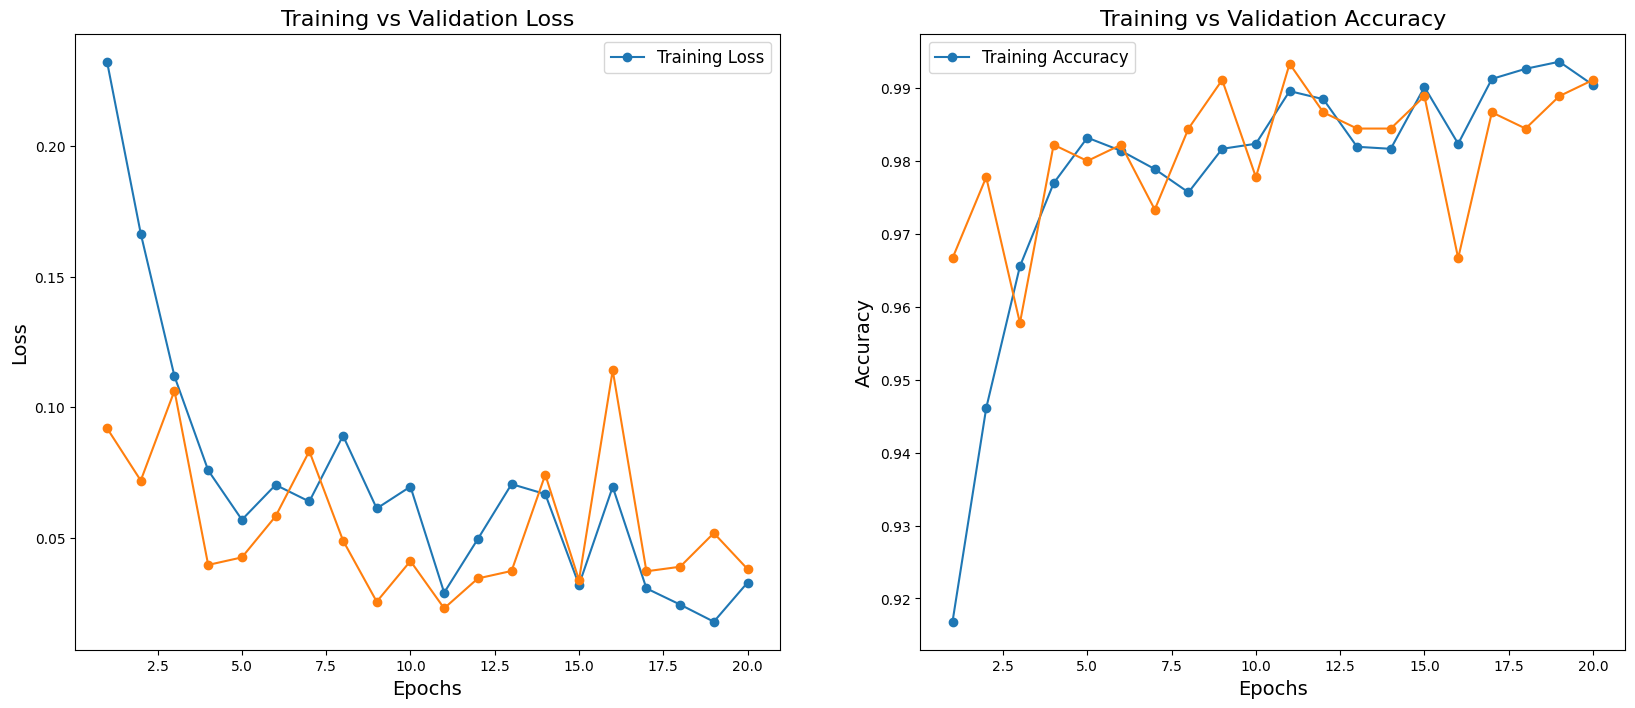

In [36]:
# Training function with learning curve
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses= []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Plot learning curve
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Confusion Matrix:
[[148   0   2]
 [  1 148   1]
 [  0   0 150]]


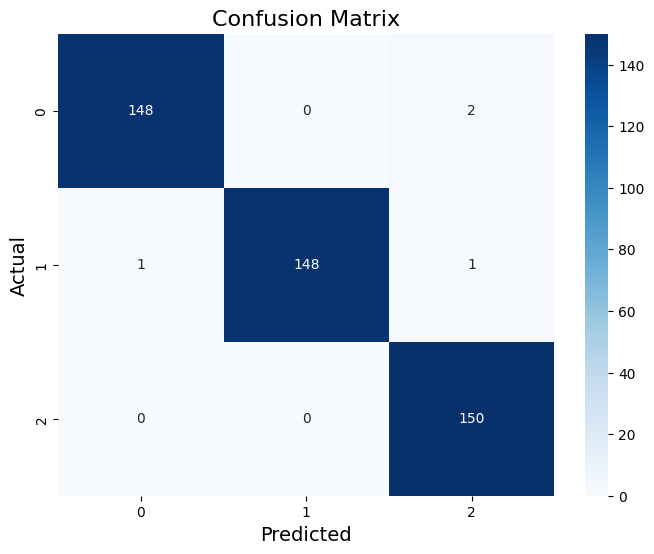

Specificity is only defined for binary classification.
Matthews Correlation Coefficient (MCC): 0.9867
F1 Score: 0.9911
PR AUC is usually computed for binary classification.

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       1.00      0.99      0.99       150
           2       0.98      1.00      0.99       150

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [37]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    # Try to fetch class names from dataset
    try:
        class_names = data_loader.dataset.classes
    except AttributeError:
        class_names = None

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Use softmax for multi-class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # For PR-AUC: assuming binary — take class 1 probability
            if probs.shape[1] == 2:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs.cpu().numpy())  # Multi-class: you can adjust this

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(len(cm)),
                yticklabels=class_names if class_names else np.arange(len(cm)))
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # --- Specificity ---
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Specificity is only defined for binary classification.")

    # --- Matthews Correlation Coefficient ---
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # --- F1 Score ---
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # --- PR AUC ---
    if len(np.unique(all_labels)) == 2:
        precision, recall, _ = precision_recall_curve(all_labels, np.array(all_probs))
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("PR AUC is usually computed for binary classification.")

    # --- Classification Report ---
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print("\nClassification Report:\n", report)
    
evaluate_model(model, val_loader)

In [38]:
# Save the model
torch.save(model.state_dict(), "nasnetmobile.pth")

In [39]:
model_nasnetlarge = model

# Ghost Net

In [40]:
import timm
import torch.nn as nn

# Create model
model = timm.create_model('ghostnet_100', pretrained=True)

# Get the number of features in the final layer
num_ftrs = model.classifier.in_features  # Access the classifier's input features

# Replace the final classification layer
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(label_mapping)),  # Use your actual number of classes
    nn.LogSoftmax(dim=1)
)

model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Ghost Net model initialized and ready for training!")

model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

Ghost Net model initialized and ready for training!


Epoch 1/20
----------


Validation Loss: 0.0613, Validation Accuracy: 0.9778
Epoch 1/20, Loss: 0.1757, Accuracy: 0.9414
Epoch 2/20
----------


Validation Loss: 0.0500, Validation Accuracy: 0.9844
Epoch 2/20, Loss: 0.0975, Accuracy: 0.9699
Epoch 3/20
----------


Validation Loss: 0.0522, Validation Accuracy: 0.9733
Epoch 3/20, Loss: 0.0484, Accuracy: 0.9853
Epoch 4/20
----------


Validation Loss: 0.0427, Validation Accuracy: 0.9867
Epoch 4/20, Loss: 0.0412, Accuracy: 0.9871
Epoch 5/20
----------


Validation Loss: 0.1024, Validation Accuracy: 0.9622
Epoch 5/20, Loss: 0.0711, Accuracy: 0.9806
Epoch 6/20
----------


Validation Loss: 0.0508, Validation Accuracy: 0.9889
Epoch 6/20, Loss: 0.0546, Accuracy: 0.9815
Epoch 7/20
----------


Validation Loss: 0.0472, Validation Accuracy: 0.9778
Epoch 7/20, Loss: 0.0531, Accuracy: 0.9856
Epoch 8/20
----------


Validation Loss: 0.0818, Validation Accuracy: 0.9778
Epoch 8/20, Loss: 0.0309, Accuracy: 0.9897
Epoch 9/20
----------


Validation Loss: 0.0184, Validation Accuracy: 0.9933
Epoch 9/20, Loss: 0.0319, Accuracy: 0.9901
Epoch 10/20
----------


Validation Loss: 0.0329, Validation Accuracy: 0.9889
Epoch 10/20, Loss: 0.0211, Accuracy: 0.9935
Epoch 11/20
----------


Validation Loss: 0.0156, Validation Accuracy: 0.9911
Epoch 11/20, Loss: 0.0299, Accuracy: 0.9911
Epoch 12/20
----------


Validation Loss: 0.0534, Validation Accuracy: 0.9822
Epoch 12/20, Loss: 0.0272, Accuracy: 0.9917
Epoch 13/20
----------


Validation Loss: 0.0350, Validation Accuracy: 0.9889
Epoch 13/20, Loss: 0.0316, Accuracy: 0.9917
Epoch 14/20
----------


Validation Loss: 0.0543, Validation Accuracy: 0.9867
Epoch 14/20, Loss: 0.0256, Accuracy: 0.9936
Epoch 15/20
----------


Validation Loss: 0.0167, Validation Accuracy: 0.9933
Epoch 15/20, Loss: 0.0264, Accuracy: 0.9931
Epoch 16/20
----------


Validation Loss: 0.0109, Validation Accuracy: 0.9978
Epoch 16/20, Loss: 0.0147, Accuracy: 0.9953
Epoch 17/20
----------


Validation Loss: 0.0372, Validation Accuracy: 0.9822
Epoch 17/20, Loss: 0.0222, Accuracy: 0.9946
Epoch 18/20
----------


Validation Loss: 0.0323, Validation Accuracy: 0.9889
Epoch 18/20, Loss: 0.0391, Accuracy: 0.9894
Epoch 19/20
----------


Validation Loss: 0.0416, Validation Accuracy: 0.9867
Epoch 19/20, Loss: 0.0247, Accuracy: 0.9932
Epoch 20/20
----------


Validation Loss: 0.0212, Validation Accuracy: 0.9911
Epoch 20/20, Loss: 0.0251, Accuracy: 0.9924


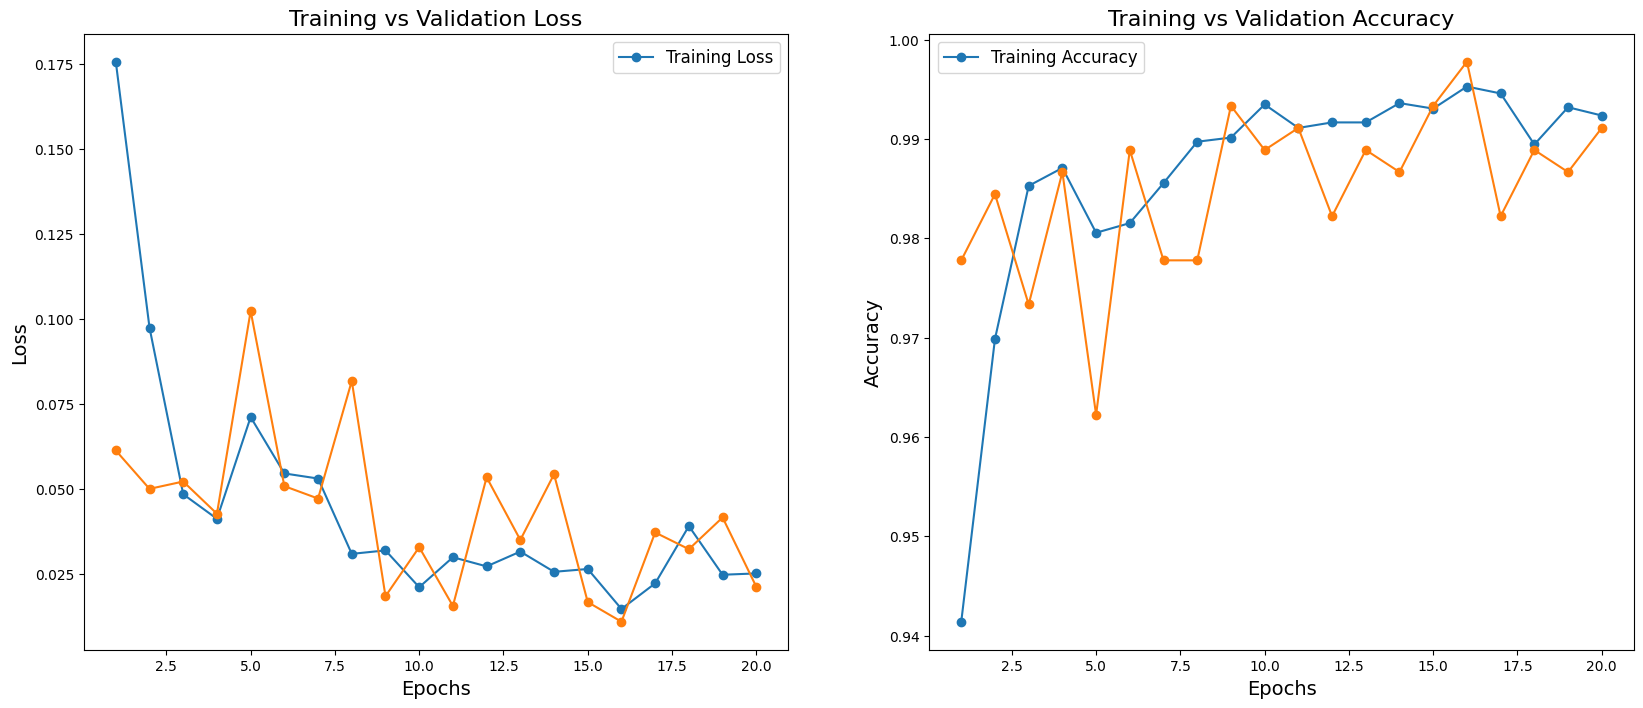

In [41]:
# Training function with learning curve
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses= []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Plot learning curve
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Confusion Matrix:
[[149   0   1]
 [  0 150   0]
 [  3   0 147]]


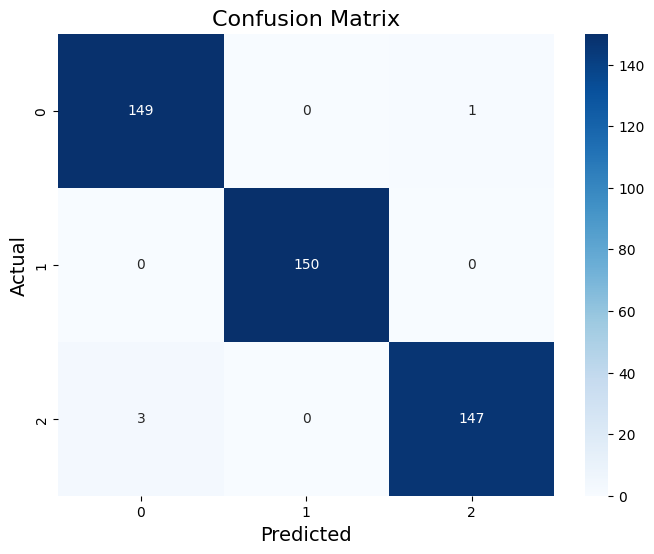

Specificity is only defined for binary classification.
Matthews Correlation Coefficient (MCC): 0.9867
F1 Score: 0.9911
PR AUC is usually computed for binary classification.

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       150
           1       1.00      1.00      1.00       150
           2       0.99      0.98      0.99       150

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [42]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    # Try to fetch class names from dataset
    try:
        class_names = data_loader.dataset.classes
    except AttributeError:
        class_names = None

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Use softmax for multi-class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # For PR-AUC: assuming binary — take class 1 probability
            if probs.shape[1] == 2:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs.cpu().numpy())  # Multi-class: you can adjust this

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(len(cm)),
                yticklabels=class_names if class_names else np.arange(len(cm)))
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # --- Specificity ---
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Specificity is only defined for binary classification.")

    # --- Matthews Correlation Coefficient ---
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # --- F1 Score ---
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # --- PR AUC ---
    if len(np.unique(all_labels)) == 2:
        precision, recall, _ = precision_recall_curve(all_labels, np.array(all_probs))
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("PR AUC is usually computed for binary classification.")

    # --- Classification Report ---
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print("\nClassification Report:\n", report)
    
evaluate_model(model, val_loader)

In [43]:
# Save the model
torch.save(model.state_dict(), "ghostnet.pth")

In [44]:
model_ghostnet = model

# Dark Net

In [45]:
import timm
import torch.nn as nn

# Install first: pip install timm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DarkNet-53
model = timm.create_model('darknet53', pretrained=True)

# Replace head (verify layer name with print(model))
num_ftrs = model.head.fc.in_features
model.head.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, len(label_mapping)),  # Use your actual number of classes
    nn.LogSoftmax(dim=1)
)

model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Dark Net model initialized and ready for training!")

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Dark Net model initialized and ready for training!


Epoch 1/20
----------


Validation Loss: 0.1533, Validation Accuracy: 0.9444
Epoch 1/20, Loss: 0.3400, Accuracy: 0.8858
Epoch 2/20
----------


Validation Loss: 0.0848, Validation Accuracy: 0.9667
Epoch 2/20, Loss: 0.1544, Accuracy: 0.9456
Epoch 3/20
----------


Validation Loss: 0.1194, Validation Accuracy: 0.9444
Epoch 3/20, Loss: 0.1438, Accuracy: 0.9519
Epoch 4/20
----------


Validation Loss: 0.0817, Validation Accuracy: 0.9733
Epoch 4/20, Loss: 0.1454, Accuracy: 0.9524
Epoch 5/20
----------


Validation Loss: 0.0346, Validation Accuracy: 0.9844
Epoch 5/20, Loss: 0.0954, Accuracy: 0.9674
Epoch 6/20
----------


Validation Loss: 0.0461, Validation Accuracy: 0.9778
Epoch 6/20, Loss: 0.0842, Accuracy: 0.9714
Epoch 7/20
----------


Validation Loss: 0.4446, Validation Accuracy: 0.9111
Epoch 7/20, Loss: 0.0920, Accuracy: 0.9719
Epoch 8/20
----------


Validation Loss: 0.0796, Validation Accuracy: 0.9711
Epoch 8/20, Loss: 0.0844, Accuracy: 0.9721
Epoch 9/20
----------


Validation Loss: 0.1021, Validation Accuracy: 0.9600
Epoch 9/20, Loss: 0.0841, Accuracy: 0.9694
Epoch 10/20
----------


Validation Loss: 0.0511, Validation Accuracy: 0.9800
Epoch 10/20, Loss: 0.0655, Accuracy: 0.9779
Epoch 11/20
----------


Validation Loss: 0.0684, Validation Accuracy: 0.9711
Epoch 11/20, Loss: 0.1009, Accuracy: 0.9669
Epoch 12/20
----------


Validation Loss: 0.0521, Validation Accuracy: 0.9800
Epoch 12/20, Loss: 0.0587, Accuracy: 0.9804
Epoch 13/20
----------


Validation Loss: 0.0535, Validation Accuracy: 0.9778
Epoch 13/20, Loss: 0.0619, Accuracy: 0.9804
Epoch 14/20
----------


Validation Loss: 0.0864, Validation Accuracy: 0.9711
Epoch 14/20, Loss: 0.0543, Accuracy: 0.9814
Epoch 15/20
----------


Validation Loss: 0.0463, Validation Accuracy: 0.9844
Epoch 15/20, Loss: 0.0492, Accuracy: 0.9869
Epoch 16/20
----------


Validation Loss: 0.0373, Validation Accuracy: 0.9889
Epoch 16/20, Loss: 0.0287, Accuracy: 0.9897
Epoch 17/20
----------


Validation Loss: 0.0483, Validation Accuracy: 0.9822
Epoch 17/20, Loss: 0.0519, Accuracy: 0.9843
Epoch 18/20
----------


Validation Loss: 0.0782, Validation Accuracy: 0.9756
Epoch 18/20, Loss: 0.0344, Accuracy: 0.9896
Epoch 19/20
----------


Validation Loss: 0.0636, Validation Accuracy: 0.9844
Epoch 19/20, Loss: 0.0340, Accuracy: 0.9882
Epoch 20/20
----------


Validation Loss: 0.0449, Validation Accuracy: 0.9844
Epoch 20/20, Loss: 0.0493, Accuracy: 0.9828


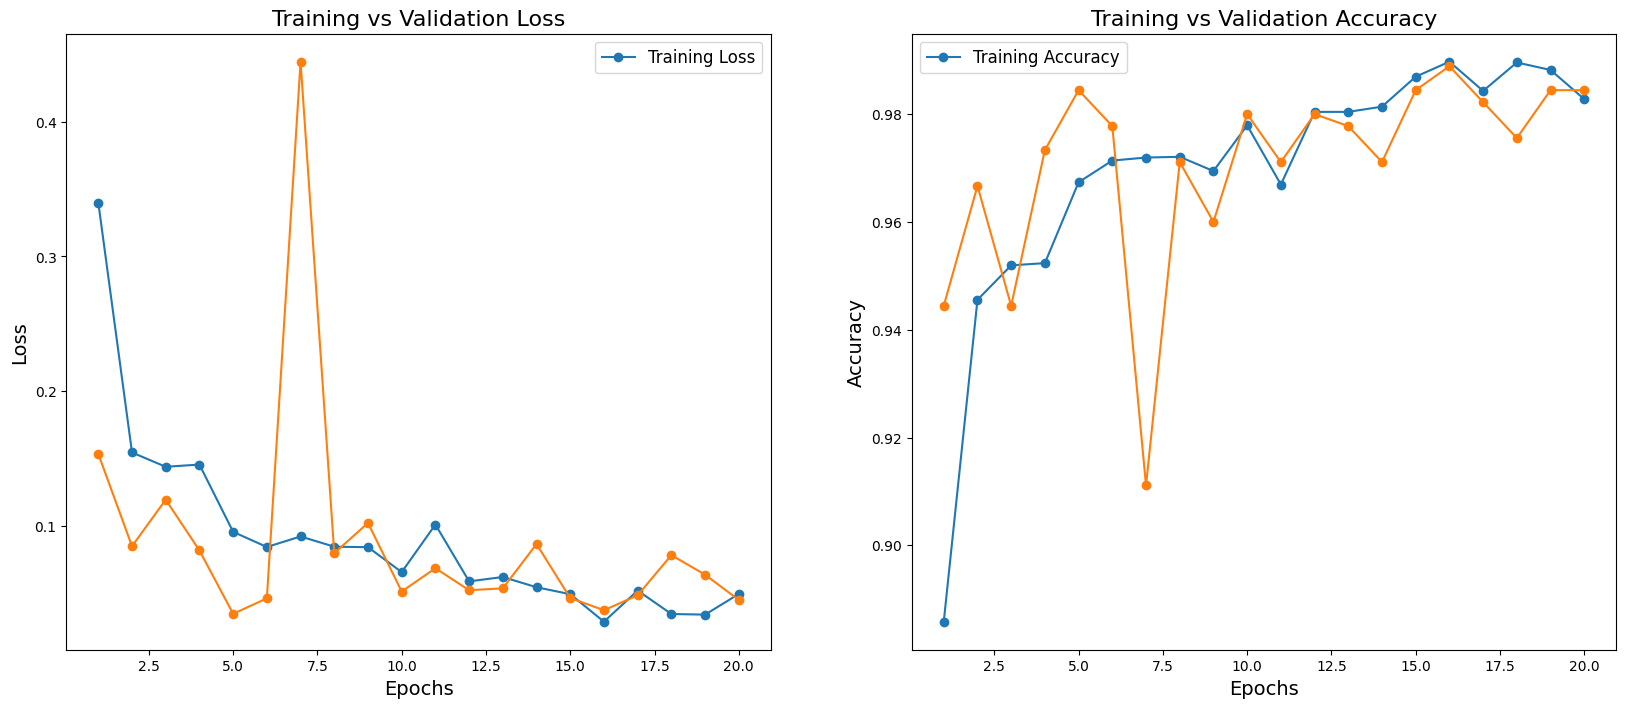

In [46]:
# Training function with learning curve
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses= []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    
    # Plot learning curve
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=16)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy')
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Confusion Matrix:
[[149   0   1]
 [  0 148   2]
 [  4   0 146]]


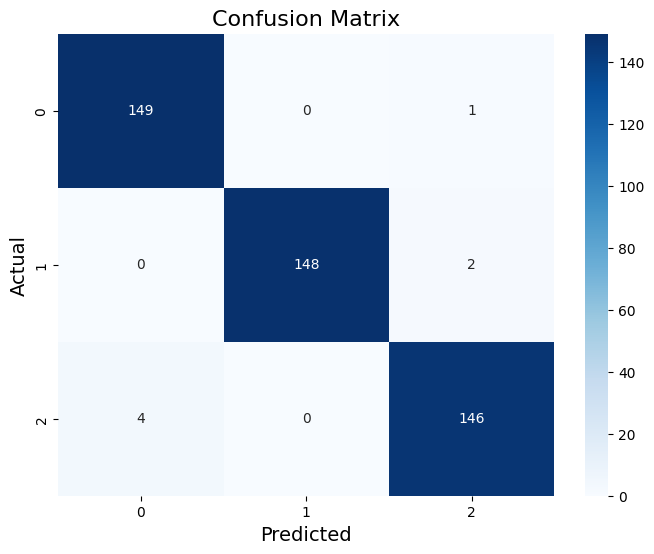

Specificity is only defined for binary classification.
Matthews Correlation Coefficient (MCC): 0.9767
F1 Score: 0.9845
PR AUC is usually computed for binary classification.

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       150
           1       1.00      0.99      0.99       150
           2       0.98      0.97      0.98       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [47]:
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    # Try to fetch class names from dataset
    try:
        class_names = data_loader.dataset.classes
    except AttributeError:
        class_names = None

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Use softmax for multi-class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # For PR-AUC: assuming binary — take class 1 probability
            if probs.shape[1] == 2:
                all_probs.extend(probs[:, 1].cpu().numpy())
            else:
                all_probs.extend(probs.cpu().numpy())  # Multi-class: you can adjust this

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else np.arange(len(cm)),
                yticklabels=class_names if class_names else np.arange(len(cm)))
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

    # --- Specificity ---
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Specificity is only defined for binary classification.")

    # --- Matthews Correlation Coefficient ---
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # --- F1 Score ---
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"F1 Score: {f1:.4f}")

    # --- PR AUC ---
    if len(np.unique(all_labels)) == 2:
        precision, recall, _ = precision_recall_curve(all_labels, np.array(all_probs))
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
    else:
        print("PR AUC is usually computed for binary classification.")

    # --- Classification Report ---
    report = classification_report(all_labels, all_preds, target_names=class_names if class_names else None)
    print("\nClassification Report:\n", report)
    
evaluate_model(model, val_loader)

In [48]:
# Save the model
torch.save(model.state_dict(), "darknet.pth")

In [49]:
model_darknet = model